# This cell is just a comment

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
from dateutil.parser import parse
from datetime import datetime, timedelta
from collections import deque

In [26]:
%matplotlib inline

print("Pandas version:      ", pd.__version__)
print("NumPy version:       ", np.__version__)
print("SciKit Learn version:", sklearn.__version__)
print("TensorFlow version:  ", tf.__version__)
print("MatPlotLib version:  ", matplotlib.__version__)

seed = 8
tf.set_random_seed(seed)
np.random.seed(seed)

Pandas version:       0.22.0
NumPy version:        1.14.0
SciKit Learn version: 0.19.1
TensorFlow version:   1.4.1
MatPlotLib version:   2.1.1


In [27]:
dataframe = pd.read_csv('data.csv')

In [28]:
dataframe.describe()

,time,close,high,low,open,volumefrom,volumeto
count,2.001000e+03,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03
mean,1.515742e+09,1213.316302,1214.347266,1212.191539,1213.279900,442.564513,5.320743e+05
std,3.466700e+04,39.986442,39.736121,40.206798,39.971723,418.918444,4.839300e+05
min,1.515682e+09,1089.330000,1089.780000,1087.610000,1089.390000,34.410000,4.123481e+04
25%,1.515712e+09,1187.730000,1188.730000,1186.640000,1187.940000,205.050000,2.504435e+05
50%,1.515742e+09,1220.590000,1221.560000,1219.640000,1220.610000,322.320000,3.891339e+05
75%,1.515772e+09,1242.590000,1243.570000,1241.420000,1242.380000,541.070000,6.511088e+05
max,1.515802e+09,1286.970000,1287.060000,1286.320000,1286.970000,8409.070000,9.139128e+06


In [29]:
desired_columns = ['close', 'high', 'low', 'open']

In [30]:
basic_mlp_data = dataframe[desired_columns]

In [31]:
basic_mlp_data.head()

,close,high,low,open
0,1197.85,1199.65,1197.46,1198.12
1,1198.36,1199.17,1196.48,1197.85
2,1198.53,1199.42,1197.02,1197.74
3,1199.84,1200.48,1198.53,1198.53
4,1201.61,1201.77,1199.59,1199.84


In [32]:
tf.reset_default_graph()

In [33]:
# Define the Neural Network topology with the 'net_hidden_sizes'
# and how much we should regularise it and how quickly it should
# learn. Also the type of non linearity we should use.
amount_epochs = 50
learning_rate = 0.001
batch_size = 128
net_hidden_sizes = [128, 64, 8]
l2_strength = 0.01
non_linearity = tf.nn.relu
dropout_amount = 0.7

In [34]:
# The input to the graph - the targets (close) and the inputs
# (open). Also a placeholder to pass a variable dropout rate. 
net_input = tf.placeholder(tf.float32, shape=[None, 1])
net_target = tf.placeholder(tf.float32, shape=[None, 1])
dropout_prob = tf.placeholder(tf.float32)

# L2 regularisation to penalise the weights from growing too
# large. Useful to prevent overfitting.
regulariser = tf.contrib.layers.l2_regularizer(scale=l2_strength)


In [36]:

# Build the network from the list of dimensions. Apply l2 and
# dropout regularisation to the layers.
net = net_input
for size in net_hidden_sizes:
    net = tf.layers.dense(inputs=net, 
                          units=size, 
                          activation=non_linearity, 
                          kernel_regularizer=regulariser)
    net = tf.layers.dropout(inputs=net,
                            rate=dropout_prob)

# The models prediction has a linear output. 
net_output = tf.layers.dense(inputs=net,
                             units=1, 
                             activation=None, 
                             kernel_regularizer=regulariser)    

# The main loss for penalising the network on how well it does.
loss = tf.losses.mean_squared_error(labels=net_target, 
                                    predictions=net_output)

# TensorFlows manner of applying l2 to the loss.
l2_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
l2_loss = tf.contrib.layers.apply_regularization(regulariser, 
                                                 l2_variables)
total_loss = loss + l2_loss

# Train and initialisation TensorFlow operations to be ran
# in the session.
train_op = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
init_op = tf.global_variables_initializer()

In [37]:
with tf.Session() as sess:
    
    amount_folds = 5
    k_folds = KFold(n_splits=amount_folds)
    data = basic_mlp_data.as_matrix()
    fold_errors = []
    fold_iteration = 0
    
    # Cross validate the dataset, using K-Fold.
    for train_indices, test_indices in k_folds.split(data):

        # Each new fold, reinitialise the network.
        sess.run(init_op)
        
        # Training phase.
        for epoch in range(amount_epochs):
            
            # Each new epoch, reshuffle the train set.
            random_train_indices = np.random.permutation(train_indices)
            train_set = data[random_train_indices]
            
            # Loop over the train set and optimise the network.
            for begin in range(0, len(train_set), batch_size):
                end = begin + batch_size
                batch_x = train_set[begin:end].T[0].reshape((-1, 1))
                batch_y = train_set[begin:end].T[1].reshape((-1, 1))
                
                sess.run(train_op, feed_dict={
                    net_input: batch_x,
                    net_target: batch_y,
                    dropout_prob: dropout_amount
                })
        
        # Testing phase.
        test_set = data[test_indices]
        
        # Collate the error over the test set.
        all_error = []
        for begin in range(0, len(test_set), batch_size):
            end = begin + batch_size 
            batch_x = train_set[begin:end].T[0].reshape((-1, 1))
            batch_y = train_set[begin:end].T[1].reshape((-1, 1))
            
            error = sess.run(loss, feed_dict={
                net_input: batch_x,
                net_target: batch_y,
                dropout_prob: 1.0
            }) 
            all_error.append(error)
        
        all_error = np.array(all_error).reshape((-1))
        fold_errors.append(all_error)
        
        print("\nFold iteration:  ", fold_iteration,
              "\nError mean:      ", np.mean(all_error),
              "\nError deviation: ", np.std(all_error),
              "\n")
        fold_iteration += 1      
        
    fold_errors = np.array(fold_errors).reshape((amount_folds, -1))


Fold iteration:   0 
Error mean:       2.0353074 
Error deviation:  0.82507384 


Fold iteration:   1 
Error mean:       1.2169592 
Error deviation:  0.33356398 


Fold iteration:   2 
Error mean:       2.0825825 
Error deviation:  0.68660593 


Fold iteration:   3 
Error mean:       1.9011098 
Error deviation:  0.60388154 


Fold iteration:   4 
Error mean:       2.2237616 
Error deviation:  0.63332665 



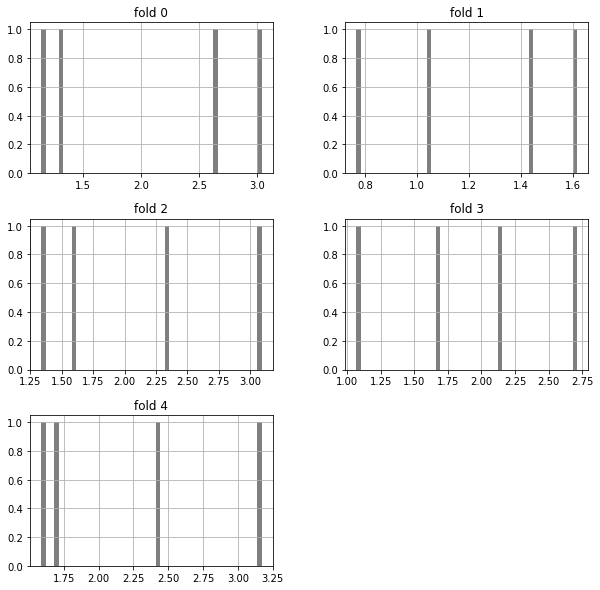

In [38]:
hist_data = dict()
keys = ['fold 0', 'fold 1', 'fold 2', 'fold 3', 'fold 4']
for i, key in enumerate(keys):
    hist_data[key] = fold_errors[i]
    

plt.figure()
hist_dataframe = pd.DataFrame(hist_data, columns=keys)
_ = hist_dataframe.hist(color='k', alpha=0.5, bins=50, figsize=(10, 10))

In [40]:
sequence_desired_cols = ['time', 'volumefrom', 'volumeto', 'close']
sequence_data = dataframe[sequence_desired_cols]
sequence_data = sequence_data.sort_values(by=['time'])
sequence_data.head()

,time,volumefrom,volumeto,close
0,1515681840,406.60,490077.26,1197.85
1,1515681900,415.94,499564.66,1198.36
2,1515681960,360.44,433644.49,1198.53
3,1515682020,392.52,472695.13,1199.84
4,1515682080,512.27,626426.66,1201.61


In [41]:
net_output

<tf.Tensor 'dense_8/BiasAdd:0' shape=(?, 1) dtype=float32>